In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_decision_forests as tfdf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [90]:
dataset = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
dataset = dataset.map(lambda x: int(x) if isinstance(x,bool) else x)

tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="Transported")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

#print(model.summary())

Use /tmp/tmpo6upuyzr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.322164. Found 8693 examples.
Training model...
Model trained in 0:00:04.330619
Compiling model...
Model compiled.


# Imports


In [91]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EXPLORATION


In [92]:
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (8693, 14)


In [93]:
#dataset_df.head(5)

In [94]:
#print(dataset_df.describe())
#dataset_df.info()

In [95]:
dataset_df = dataset_df.drop(['PassengerId', 'Name'], axis=1)

In [96]:
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [97]:
#dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [98]:
dataset_df = dataset_df.map(lambda x: int(x) if isinstance(x,bool) else x)

In [99]:
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)
try:
    dataset_df = dataset_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

In [100]:
#dataset_df.head(5)

# More visualisation

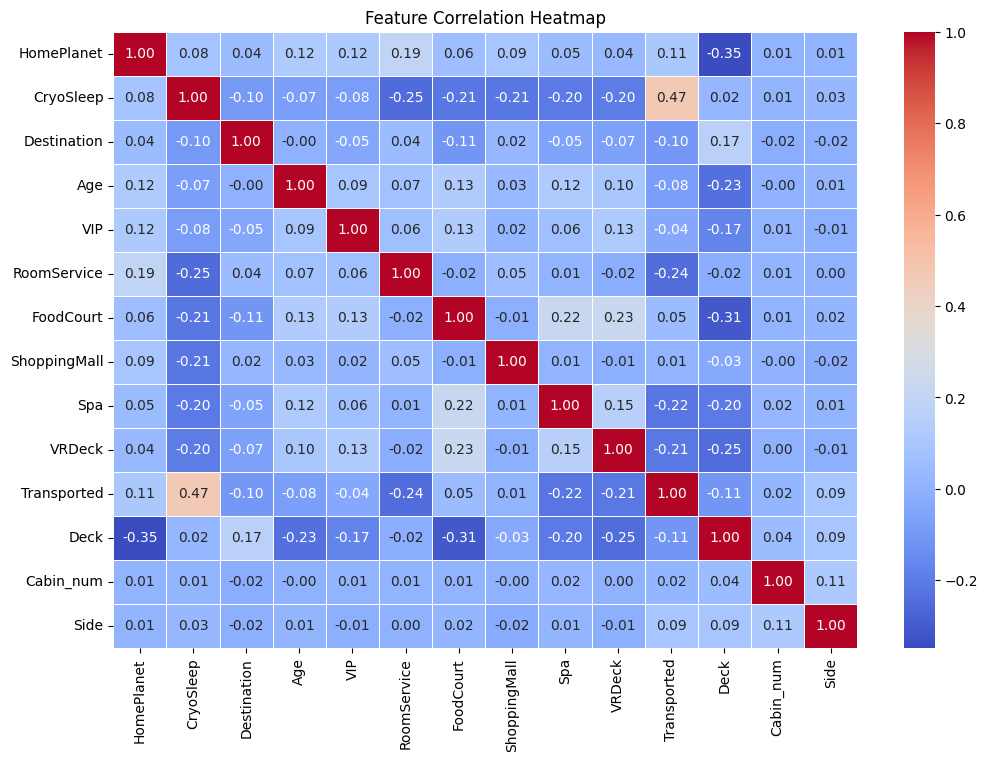

In [101]:
from sklearn.preprocessing import LabelEncoder
df = dataset_df.copy()

# Znalezienie kolumn kategorycznych
cat_cols = df.select_dtypes(include=['object']).columns

# Konwersja zmiennych kategorycznych na liczby (Label Encoding)
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))  # Konwersja na string dla pewności

# Wyświetlenie heatmapy z wszystkimi kolumnami
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

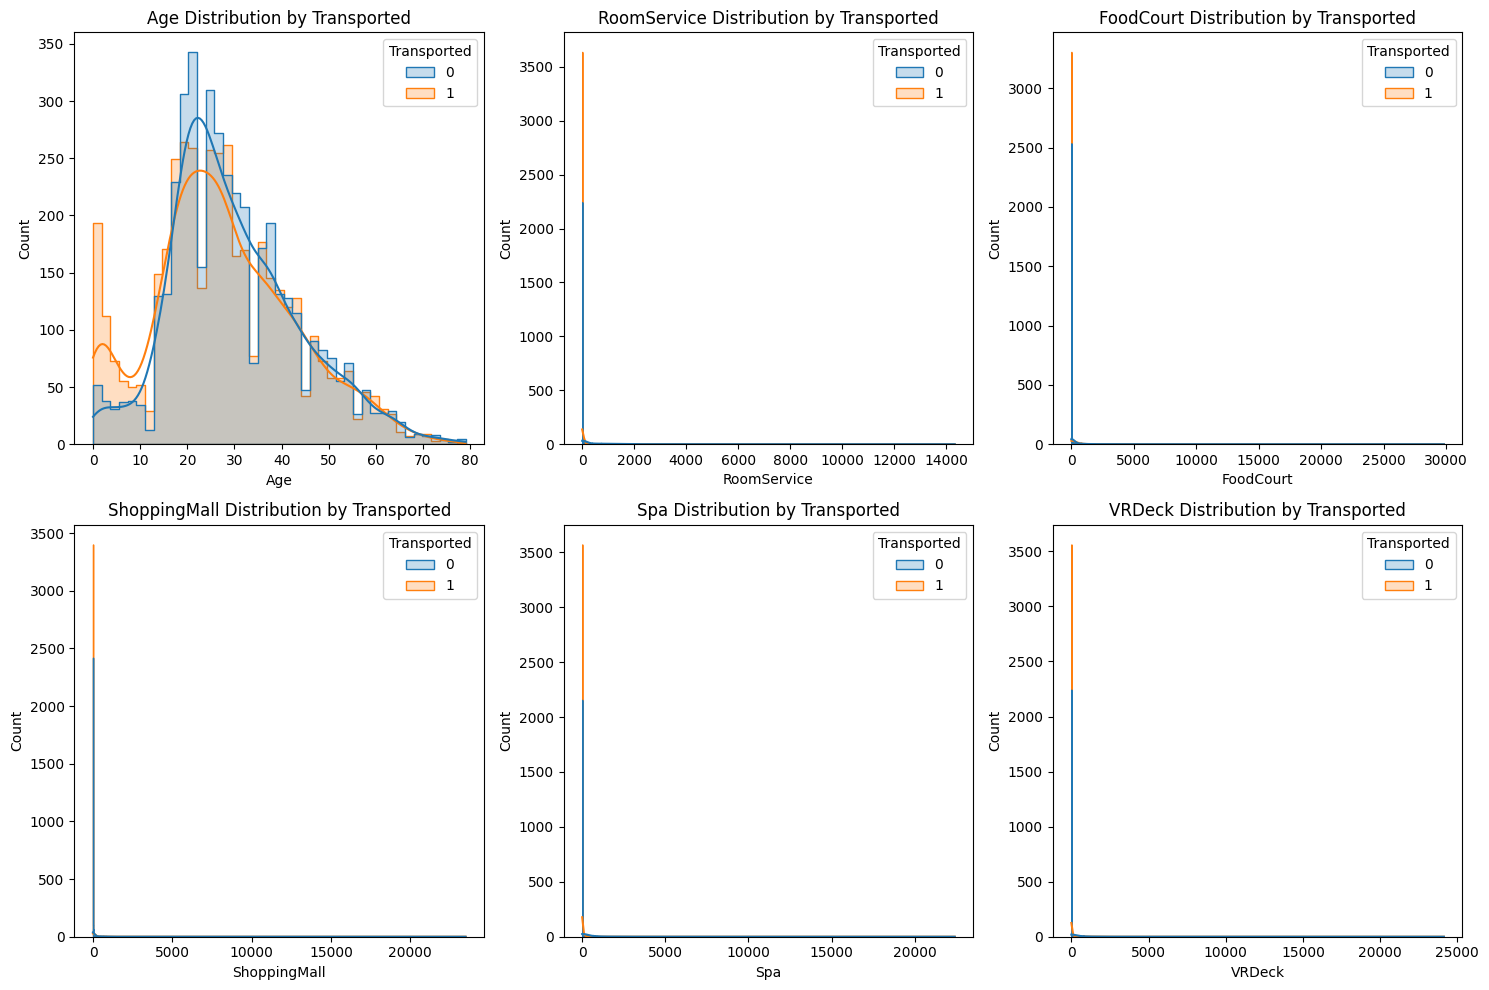

In [102]:
# 3. Feature Distributions by Target
fig, axes = plt.subplots(2, 3, figsize=(15,10))
num_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for i, feature in enumerate(num_features):
    sns.histplot(data=dataset_df, x=feature, hue="Transported", element="step", kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"{feature} Distribution by Transported")
plt.tight_layout()
plt.show()

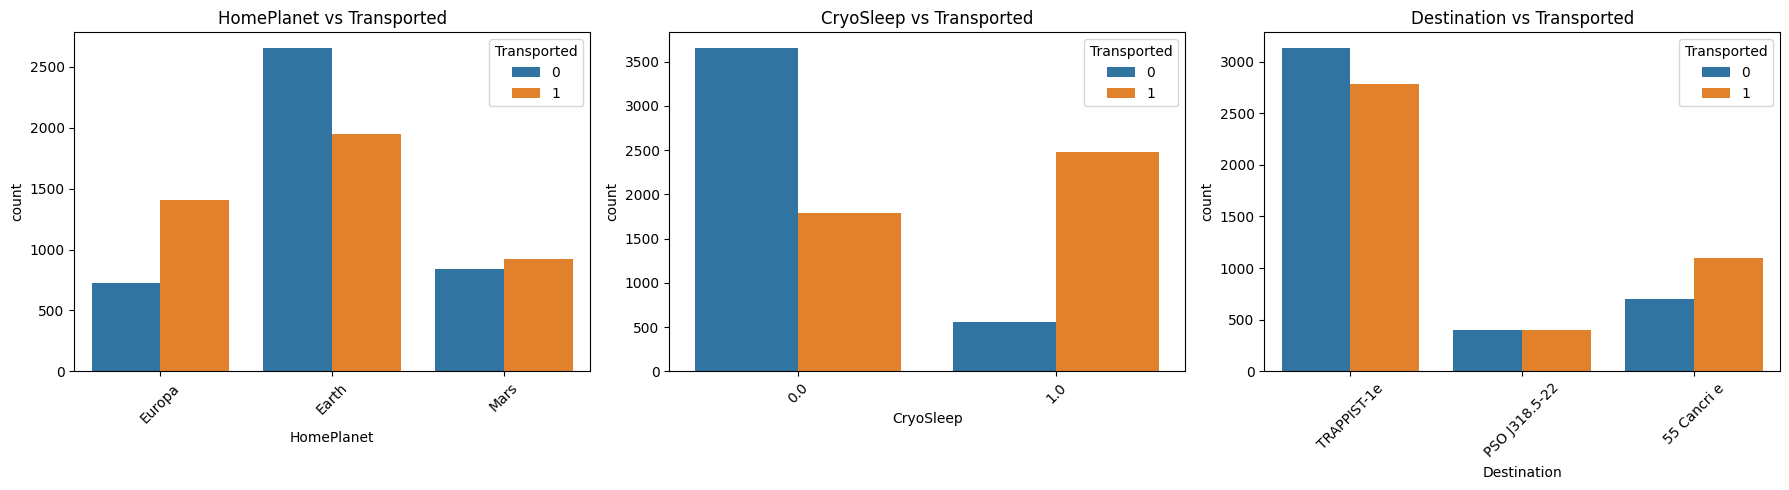

In [103]:
# 5. Categorical Feature Impact
fig, axes = plt.subplots(1, 3, figsize=(18,5))
categories = ["HomePlanet", "CryoSleep", "Destination"]
for i, cat in enumerate(categories):
    sns.countplot(data=dataset_df, x=cat, hue="Transported", ax=axes[i], palette=["#1f77b4", "#ff7f0e"])
    axes[i].set_title(f"{cat} vs Transported")
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Working on features


In [104]:
df.groupby("CryoSleep")["Transported"].mean()

CryoSleep
0.0    0.328921
1.0    0.817583
Name: Transported, dtype: float64

In [105]:
df["CryoSleep_HomePlanet"] = df["CryoSleep"].astype(str) + "_" + df["HomePlanet"].astype(str)
df = pd.get_dummies(df, columns=["CryoSleep_HomePlanet"], drop_first=True)
df["AgeGroup"] = pd.cut(df["Age"], bins=[0, 12, 18, 30, 50, 100], labels=["Child", "Teen", "YoungAdult", "Adult", "Senior"])
df["CryoSleep_AgeGroup"] = df["CryoSleep"].astype(str) + "_" + df["AgeGroup"].astype(str)
df = pd.get_dummies(df, columns=["CryoSleep_AgeGroup"], drop_first=True)
df["AgeGroup"] = df["AgeGroup"].astype(str)
df["CryoSleep"] = df["CryoSleep"].astype(str)

df = df.map(lambda x: int(x) if isinstance(x,bool) else x)

Drop all rows with NaN

In [106]:
#cleaned_df_1 = dataset_df.dropna()
#dropped_rows = len(dataset_df) - len(cleaned_df)
#print(f"Approach 1: Dropped {dropped_rows} rows due to missing values.")

Fill NaN with 0


In [107]:
#cleaned_df_2 = dataset_df.fillna(value=0) 
#print(f"Approach 2: Replaced all NaN values with 0.")

Replace NaN with median (for numerical) and most frequent (for categorical)

In [108]:
cleaned_df = df.copy()

# List of numerical and categorical columns
numerical_columns = ['RoomService', 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num']
categorical_columns = ['HomePlanet', 'CryoSleep', 'Deck', 'Side', 'Destination', 'VIP', 'Name']

# Check if 'Name' column exists in the DataFrame, and remove it from categorical_columns if it's missing
if 'Name' not in cleaned_df.columns:
    categorical_columns.remove('Name')

# Handle potential non-numeric issues in 'Cabin_num' by converting it to numeric
cleaned_df['Cabin_num'] = pd.to_numeric(cleaned_df['Cabin_num'], errors='coerce')

# Fill numerical columns with median (direct assignment)
for col in numerical_columns:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())

# Fill categorical columns with the most frequent value (direct assignment)
for col in categorical_columns:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].mode()[0])


In [109]:
#dataset_df["TotalSpending"] = dataset_df["VRDeck"] + dataset_df["Spa"] + dataset_df["RoomService"]
#dataset_df["SpentMoney"] = (dataset_df["TotalSpending"] > 0).astype(int)

In [110]:
from sklearn.decomposition import PCA  
from sklearn.preprocessing import StandardScaler  

# Standardize the correlated features
scaler = StandardScaler()
spending_features = cleaned_df[["VRDeck", "Spa", "RoomService"]].fillna(0)  # Fill NaNs if needed
spending_scaled = scaler.fit_transform(spending_features)

# Apply PCA
pca = PCA(n_components=1)  # Reduce to 1 feature
cleaned_df["Spending_PCA"] = pca.fit_transform(spending_scaled)

# Drop the original columns used for PCA
cleaned_df.drop(columns=["VRDeck", "Spa", "RoomService"], inplace=True)

# Verify the changes
#print(cleaned_df.head())

# Training


In [120]:
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% test by default)
train_ds_pd, valid_ds_pd = train_test_split(cleaned_df, test_size=0.2, random_state=42)


# Print dataset sizes
print(f"{len(train_ds_pd)} examples in training, {len(valid_ds_pd)} examples in testing.")

train_ds_pd["CryoSleep"] = train_ds_pd["CryoSleep"].map({"True": 1, "False": 0})
train_ds_pd["CryoSleep"] = train_ds_pd["CryoSleep"].fillna(-1) 
age_mapping = {"Child": 0, "Teen": 1, "YoungAdult": 2, "Adult": 3, "Senior": 4}
train_ds_pd["AgeGroup"] = train_ds_pd["AgeGroup"].map(age_mapping)
train_ds_pd["AgeGroup"] = train_ds_pd["AgeGroup"].fillna(-1) 


valid_ds_pd["CryoSleep"] = valid_ds_pd["CryoSleep"].map({"True": 1, "False": 0})
valid_ds_pd["CryoSleep"] = valid_ds_pd["CryoSleep"].fillna(-1) 
age_mapping = {"Child": 0, "Teen": 1, "YoungAdult": 2, "Adult": 3, "Senior": 4}
valid_ds_pd["AgeGroup"] = valid_ds_pd["AgeGroup"].map(age_mapping)
valid_ds_pd["AgeGroup"] = valid_ds_pd["AgeGroup"].fillna(-1) 

6954 examples in training, 1739 examples in testing.


In [121]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="Transported")
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="Transported")

In [113]:
#tfdf.keras.get_all_models()

In [122]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")
rf.compile(metrics=["accuracy"])

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpig2j1r5i as temporary training directory


In [123]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.726739. Found 6954 examples.
Training model...
Model trained in 0:00:23.207412
Compiling model...
Model compiled.


In [116]:
#tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

In [124]:
inspector = rf.make_inspector()
print(inspector.evaluation())


Evaluation(num_examples=6954, accuracy=0.8088869715271786, loss=0.482905054441767, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


In [125]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")


2/2 [==============================] - 0s 88ms/step - loss: 0.0000e+00 - accuracy: 0.7930
loss: 0.0000
accuracy: 0.7930


In [126]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)
inspector.variable_importances()["NUM_AS_ROOT"]

Available variable importances:
	 NUM_NODES
	 SUM_SCORE
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH


[("Spending_PCA" (1; #38), 78.0),
 ("CryoSleep_HomePlanet_1.0_1" (1; #25), 37.0),
 ("CryoSleep_AgeGroup_0.0_Senior" (1; #5), 11.0),
 ("CryoSleep_AgeGroup_1.0_Child" (1; #10), 11.0),
 ("Age" (1; #0), 10.0),
 ("CryoSleep_AgeGroup_0.0_Child" (1; #4), 10.0),
 ("CryoSleep_AgeGroup_1.0_nan" (1; #14), 10.0),
 ("CryoSleep_AgeGroup_0.0_YoungAdult" (1; #7), 9.0),
 ("CryoSleep_HomePlanet_0.0_3" (1; #23), 9.0),
 ("CryoSleep_AgeGroup_0.0_Teen" (1; #6), 8.0),
 ("CryoSleep_AgeGroup_1.0_Adult" (1; #9), 8.0),
 ("CryoSleep_AgeGroup_nan_nan" (1; #20), 8.0),
 ("CryoSleep_AgeGroup_1.0_YoungAdult" (1; #13), 7.0),
 ("CryoSleep_AgeGroup_nan_Child" (1; #16), 6.0),
 ("CryoSleep_AgeGroup_nan_Teen" (1; #18), 6.0),
 ("CryoSleep_HomePlanet_0.0_1" (1; #21), 6.0),
 ("CryoSleep_HomePlanet_0.0_2" (1; #22), 6.0),
 ("CryoSleep_HomePlanet_1.0_3" (1; #27), 6.0),
 ("AgeGroup" (1; #1), 5.0),
 ("CryoSleep_AgeGroup_0.0_nan" (1; #8), 5.0),
 ("CryoSleep_AgeGroup_1.0_Senior" (1; #11), 5.0),
 ("CryoSleep_AgeGroup_1.0_Teen" (1; #12

# Submission


In [130]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow_decision_forests as tfdf

# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df["PassengerId"]

# Fill missing values
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Create new features from Cabin
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df.drop(columns=['Cabin'], inplace=True)

# Convert boolean features to 0s and 1s
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# --- APPLY PCA ON TEST DATASET ---
spending_features = ["VRDeck", "Spa", "RoomService"]

# Fill NaNs with 0 for consistency
test_df[spending_features] = test_df[spending_features].fillna(0)

# Standardize using the same scaler as training
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test_df[spending_features])

# Apply PCA (same model as used in training)
pca = PCA(n_components=1)
test_df["Spending_PCA"] = pca.fit_transform(test_scaled)

# Drop original spending features after PCA transformation
test_df.drop(columns=spending_features, inplace=True)

# Drop any extra columns not used in training
train_features = ['Age', 'Spending_PCA', 'ShoppingMall', "FoodCourt",  'Cabin_num','HomePlanet', 'CryoSleep', 'Deck', 'Side', 'Destination', 'VIP']
test_df = test_df[train_features]
test_df['Cabin_num'] = pd.to_numeric(test_df['Cabin_num'], errors='coerce')
test_df["CryoSleep"] = test_df["CryoSleep"].map({"True": 1, "False": 0})
test_df["CryoSleep"] = test_df["CryoSleep"].fillna(-1)
test_df["CryoSleep_HomePlanet"] = test_df["CryoSleep"].astype(str) + "_" + test_df["HomePlanet"].astype(str)

# Tworzenie zmiennych dummy dla CryoSleep_HomePlanet
test_df = pd.get_dummies(test_df, columns=["CryoSleep_HomePlanet"], drop_first=True)

# Tworzenie kolumny AgeGroup
test_df["AgeGroup"] = pd.cut(test_df["Age"], bins=[0, 12, 18, 30, 50, 100], labels=["Child", "Teen", "YoungAdult", "Adult", "Senior"])

# Tworzenie kolumny CryoSleep_AgeGroup
test_df["CryoSleep_AgeGroup"] = test_df["CryoSleep"].astype(str) + "_" + test_df["AgeGroup"].astype(str)

# Tworzenie zmiennych dummy dla CryoSleep_AgeGroup
test_df = pd.get_dummies(test_df, columns=["CryoSleep_AgeGroup"], drop_first=True)

# Konwersja AgeGroup i CryoSleep na typ str
test_df["AgeGroup"] = test_df["AgeGroup"].astype(str)
test_df["CryoSleep"] = test_df["CryoSleep"].astype(str)

# Przekształcenie kolumn z wartościami boolowskimi na int
test_df = test_df.apply(lambda x: x.map(lambda v: int(v) if isinstance(v, bool) else v))
# Mapowanie grup wiekowych na wartości liczbowe i wypełnianie braków -1
age_mapping = {"Child": 0, "Teen": 1, "YoungAdult": 2, "Adult": 3, "Senior": 4}
test_df["AgeGroup"] = test_df["AgeGroup"].map(age_mapping)
test_df["AgeGroup"] = test_df["AgeGroup"].fillna(-1)
# Convert DataFrame to TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get predictions for test data
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)

# Create submission file
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tensorflow_decision_forests/keras/core_inference.py", line 486, in run_step  *
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 2377, in predict_step  **
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filertsn9j9g.py", line 232, in tf__call
        ag__.if_stmt(ag__.ld(self)._semantics is None, if_body_8, else_body_8, get_state_11, set_state_11, ('do_return', 'retval_'), 2)
    File "/tmp/__autograph_generated_filertsn9j9g.py", line 43, in else_body_8
        normalized_inputs = ag__.converted_call(ag__.ld(self)._build_normalized_inputs, (ag__.ld(inputs),), None, fscope)
    File "/tmp/__autograph_generated_filex22awloh.py", line 98, in tf___build_normalized_inputs
        semantic_inputs = ag__.converted_call(ag__.ld(tf_core).combine_tensors_and_semantics, (ag__.ld(inputs), ag__.ld(self)._semantics), None, fscope)
    File "/tmp/__autograph_generated_filei6_ykbep.py", line 34, in tf__combine_tensors_and_semantics
        ag__.if_stmt(ag__.not_(ag__.converted_call(ag__.converted_call(ag__.ld(set), (ag__.converted_call(ag__.ld(semantics).keys, (), None, fscope),), None, fscope).issubset, (ag__.converted_call(ag__.ld(inputs).keys, (), None, fscope),), None, fscope)), if_body, else_body, get_state, set_state, (), 0)
    File "/tmp/__autograph_generated_filei6_ykbep.py", line 30, in if_body
        raise ag__.converted_call(ag__.ld(ValueError), (ag__.converted_call('semantics is not a subset of inputs (inputs={} vs semantics={}).'.format, (ag__.converted_call(ag__.ld(inputs).keys, (), None, fscope), ag__.converted_call(ag__.ld(semantics).keys, (), None, fscope)), None, fscope),), None, fscope)

    ValueError: Exception encountered when calling layer 'random_forest_model_5' (type RandomForestModel).
    
    in user code:
    
        File "/usr/local/lib/python3.10/dist-packages/tensorflow_decision_forests/keras/core_inference.py", line 672, in call  *
            normalized_inputs = self._build_normalized_inputs(inputs)
        File "/usr/local/lib/python3.10/dist-packages/tensorflow_decision_forests/keras/core_inference.py", line 631, in _build_normalized_inputs  *
            semantic_inputs = tf_core.combine_tensors_and_semantics(
        File "/usr/local/lib/python3.10/dist-packages/tensorflow_decision_forests/tensorflow/core_inference.py", line 431, in combine_tensors_and_semantics  *
            raise ValueError("semantics is not a subset of inputs "
    
        ValueError: semantics is not a subset of inputs (inputs=dict_keys(['Age', 'Spending_PCA', 'ShoppingMall', 'FoodCourt', 'Cabin_num', 'HomePlanet', 'CryoSleep', 'Deck', 'Side', 'Destination', 'VIP', 'CryoSleep_HomePlanet_-1.0_Europa', 'CryoSleep_HomePlanet_-1.0_Mars', 'CryoSleep_HomePlanet_-1.0_nan', 'AgeGroup', 'CryoSleep_AgeGroup_-1.0_Child', 'CryoSleep_AgeGroup_-1.0_Senior', 'CryoSleep_AgeGroup_-1.0_Teen', 'CryoSleep_AgeGroup_-1.0_YoungAdult', 'CryoSleep_AgeGroup_-1.0_nan']) vs semantics=dict_keys(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'FoodCourt', 'ShoppingMall', 'Deck', 'Cabin_num', 'Side', 'CryoSleep_HomePlanet_0.0_1', 'CryoSleep_HomePlanet_0.0_2', 'CryoSleep_HomePlanet_0.0_3', 'CryoSleep_HomePlanet_1.0_0', 'CryoSleep_HomePlanet_1.0_1', 'CryoSleep_HomePlanet_1.0_2', 'CryoSleep_HomePlanet_1.0_3', 'CryoSleep_HomePlanet_nan_0', 'CryoSleep_HomePlanet_nan_1', 'CryoSleep_HomePlanet_nan_2', 'CryoSleep_HomePlanet_nan_3', 'AgeGroup', 'CryoSleep_AgeGroup_0.0_Child', 'CryoSleep_AgeGroup_0.0_Senior', 'CryoSleep_AgeGroup_0.0_Teen', 'CryoSleep_AgeGroup_0.0_YoungAdult', 'CryoSleep_AgeGroup_0.0_nan', 'CryoSleep_AgeGroup_1.0_Adult', 'CryoSleep_AgeGroup_1.0_Child', 'CryoSleep_AgeGroup_1.0_Senior', 'CryoSleep_AgeGroup_1.0_Teen', 'CryoSleep_AgeGroup_1.0_YoungAdult', 'CryoSleep_AgeGroup_1.0_nan', 'CryoSleep_AgeGroup_nan_Adult', 'CryoSleep_AgeGroup_nan_Child', 'CryoSleep_AgeGroup_nan_Senior', 'CryoSleep_AgeGroup_nan_Teen', 'CryoSleep_AgeGroup_nan_YoungAdult', 'CryoSleep_AgeGroup_nan_nan', 'Spending_PCA'])).
    
    
    Call arguments received by layer 'random_forest_model_5' (type RandomForestModel):
      • inputs={'Age': 'tf.Tensor(shape=(None,), dtype=float32)', 'Spending_PCA': 'tf.Tensor(shape=(None,), dtype=float32)', 'ShoppingMall': 'tf.Tensor(shape=(None,), dtype=float32)', 'FoodCourt': 'tf.Tensor(shape=(None,), dtype=float32)', 'Cabin_num': 'tf.Tensor(shape=(None,), dtype=float32)', 'HomePlanet': 'tf.Tensor(shape=(None,), dtype=string)', 'CryoSleep': 'tf.Tensor(shape=(None,), dtype=string)', 'Deck': 'tf.Tensor(shape=(None,), dtype=string)', 'Side': 'tf.Tensor(shape=(None,), dtype=string)', 'Destination': 'tf.Tensor(shape=(None,), dtype=string)', 'VIP': 'tf.Tensor(shape=(None,), dtype=int64)', 'CryoSleep_HomePlanet_-1.0_Europa': 'tf.Tensor(shape=(None,), dtype=int64)', 'CryoSleep_HomePlanet_-1.0_Mars': 'tf.Tensor(shape=(None,), dtype=int64)', 'CryoSleep_HomePlanet_-1.0_nan': 'tf.Tensor(shape=(None,), dtype=int64)', 'AgeGroup': 'tf.Tensor(shape=(None,), dtype=float32)', 'CryoSleep_AgeGroup_-1.0_Child': 'tf.Tensor(shape=(None,), dtype=int64)', 'CryoSleep_AgeGroup_-1.0_Senior': 'tf.Tensor(shape=(None,), dtype=int64)', 'CryoSleep_AgeGroup_-1.0_Teen': 'tf.Tensor(shape=(None,), dtype=int64)', 'CryoSleep_AgeGroup_-1.0_YoungAdult': 'tf.Tensor(shape=(None,), dtype=int64)', 'CryoSleep_AgeGroup_-1.0_nan': 'tf.Tensor(shape=(None,), dtype=int64)'}
      • training=False


In [ ]:
output.to_csv('/kaggle/working/submission.csv', index=False)
output.head()

# Extra visualisation

In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()